# Data setup and Preprocessing

 **Mounting the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdown

In [ ]:
!gdown 18zxIeRIl1rSWSOy7823TuRbk_HoGE161

Downloading...
From (original): https://drive.google.com/uc?id=18zxIeRIl1rSWSOy7823TuRbk_HoGE161
From (redirected): https://drive.google.com/uc?id=18zxIeRIl1rSWSOy7823TuRbk_HoGE161&confirm=t&uuid=83b57ee0-0b96-4ef5-a3a9-9a7996f44da0
To: /content/Skin Cancer Classification.zip
100% 824M/824M [00:17<00:00, 47.8MB/s]


In [ ]:
!unzip Skin\ Cancer\ Classification.zip

Archive:  Skin Cancer Classification.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cance

In [ ]:
#Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
TRAIN_DIR = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
TEST_DIR  = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [ ]:
# List class subfolders and count images
classes = sorted(os.listdir(TRAIN_DIR))
image_counts = {c: len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in classes}
total_images = sum(image_counts.values())

print(f"Total images: {total_images}")
print("Class distribution:", image_counts)

Total images: 2239
Class distribution: {'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


<ipython-input-8-3fd2256f4928>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette='Blues_d')


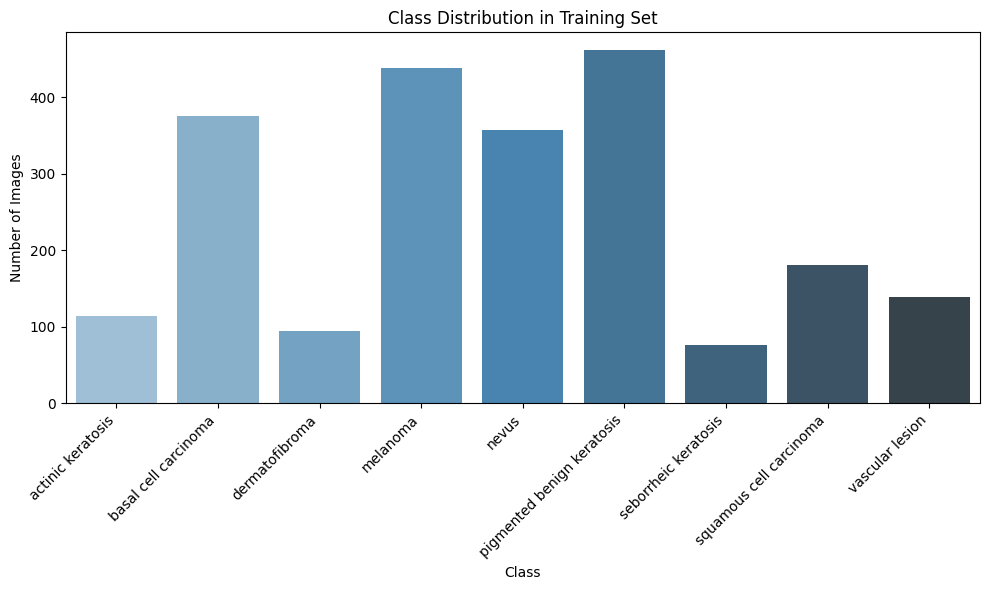

In [ ]:
# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette='Blues_d')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#  Data Generators & Augmentation

IMG_SIZE = (224, 224)
BATCH    = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [ ]:
#  Clean Corrupted Images

def remove_corrupted_images(root_folder):
    deleted = 0
    for subdir, _, files in os.walk(root_folder):
        for fname in files:
            fpath = os.path.join(subdir, fname)
            try:
                img = Image.open(fpath)
                img.verify()
            except Exception:
                os.remove(fpath)
                deleted += 1
    print(f"Removed {deleted} corrupted images from {root_folder!r}")

remove_corrupted_images(TRAIN_DIR)
remove_corrupted_images(TEST_DIR)

Removed 0 corrupted images from '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
Removed 0 corrupted images from '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'


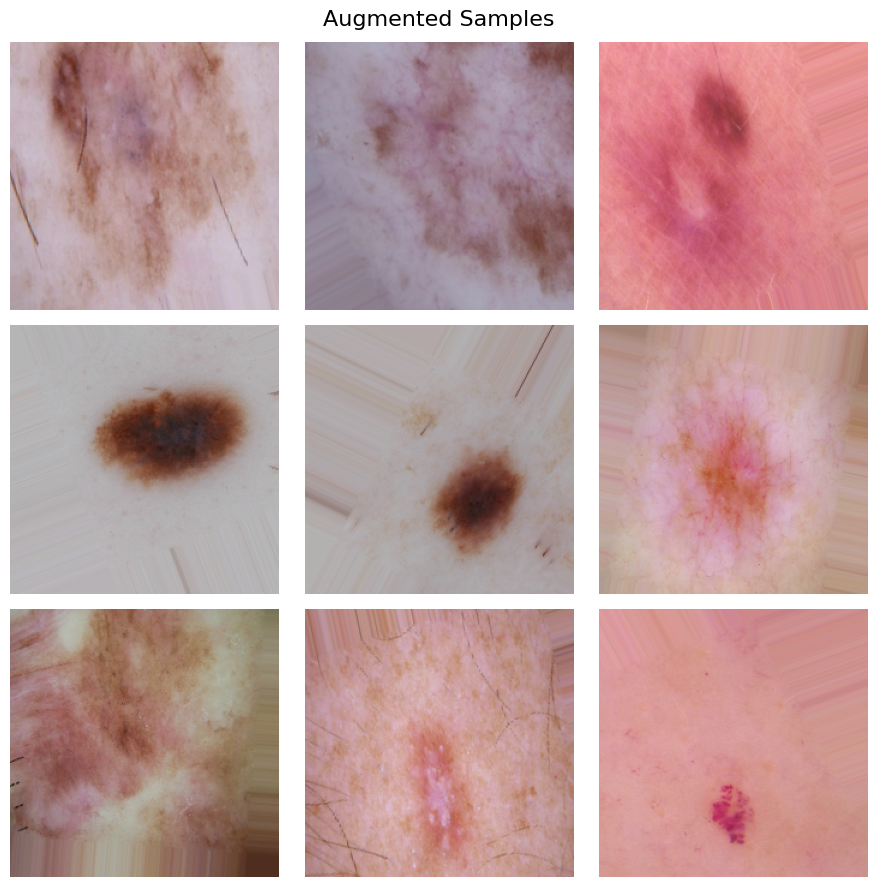

In [ ]:
# augmented images
import matplotlib.pyplot as plt


images, _ = next(train_generator)

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.suptitle("Augmented Samples", fontsize=16)
plt.tight_layout()
plt.show()


# Baseline CNN Model

In [ ]:
# 1. Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
TRAIN_DIR = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
IMG_SIZE  = (224, 224)
BATCH     = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [ ]:
# 2. Compute class weights (on your training split)
y_train = train_generator.classes
classes = list(train_generator.class_indices.keys())

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(2.167874396135266), 1: np.float64(0.6626061277224068), 2: np.float64(2.624269005847953), 3: np.float64(0.5682177904400126), 4: np.float64(0.6973581973581974), 5: np.float64(0.539039039039039), 6: np.float64(3.216845878136201), 7: np.float64(1.3754789272030652), 8: np.float64(1.7807539682539681)}


In [ ]:
# 3. Build & compile the baseline CNN

num_classes = len(classes)

model = Sequential([
    Input(shape=(224, 224, 3)),

    # Conv block 1
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Conv block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Conv block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Dense head
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64,  activation='relu'),
    Dense(32,  activation='relu'),

    # Output
    Dense(num_classes, activation='softmax'),
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,593 (42.65 MB)

 Trainable params: 11,179,593 (42.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#  Train with class weights & early stopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 873ms/step - accuracy: 0.1670 - loss: 2.2081 - val_accuracy: 0.2568 - val_loss: 2.1294
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 842ms/step - accuracy: 0.2413 - loss: 2.1400 - val_accuracy: 0.2748 - val_loss: 2.0422
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 45s 790ms/step - accuracy: 0.2827 - loss: 2.0193 - val_accuracy: 0.2703 - val_loss: 1.9024
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 813ms/step - accuracy: 0.2812 - loss: 1.9588 - val_accuracy: 0.2387 - val_loss: 1.8573
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 46s 808ms/step - accuracy: 0.2552 - loss: 1.8902 - val_accuracy: 0.3468 - val_loss: 1.7511
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 770ms/step - accuracy: 0.3333 - loss: 1.8358 - val_accuracy: 0.3221 - val_loss: 1.8136
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 769ms/step - accuracy: 0.3636 - loss: 1.7172 - val_accuracy: 0.2928 - val_loss: 1.7914
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 762ms/step - accuracy: 0.3427 - loss: 1.7136 - val_accu

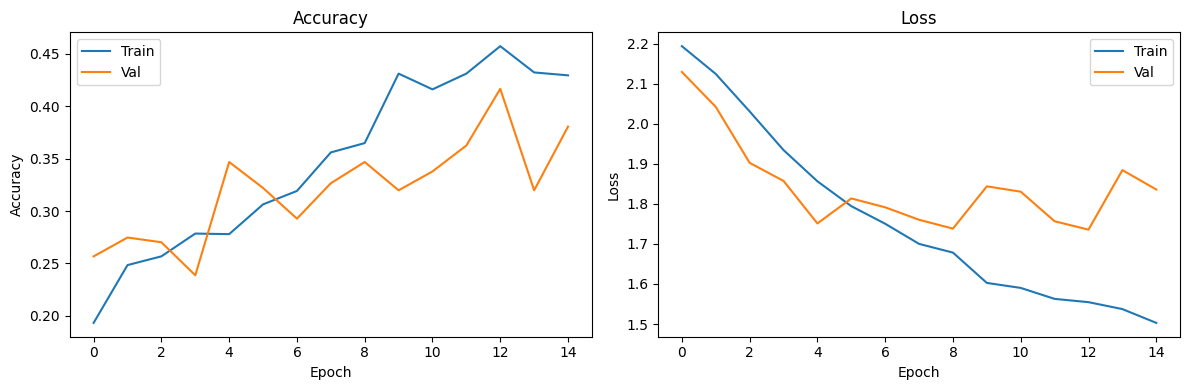

In [ ]:
# Plot training curves

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#  Predictions
steps = len(val_generator)
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator, steps=steps), axis=1)

class_labels = list(val_generator.class_indices.keys())

#  Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm= confusion_matrix(y_true, y_pred)


14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 771ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.10      0.23      0.14        22
      basal cell carcinoma       0.17      0.13      0.15        75
            dermatofibroma       0.00      0.00      0.00        19
                  melanoma       0.33      0.15      0.20        87
                     nevus       0.15      0.18      0.17        71
pigmented benign keratosis       0.16      0.16      0.16        92
      seborrheic keratosis       0.04      0.07      0.05        15
   squamous cell carcinoma       0.07      0.06      0.06        36
           vascular lesion       0.04      0.07      0.05        27

                  accuracy                           0.14       444
                 macro avg       0.12      0.12      0.11       444
              weighted avg       0.16      0.14      0.14       444



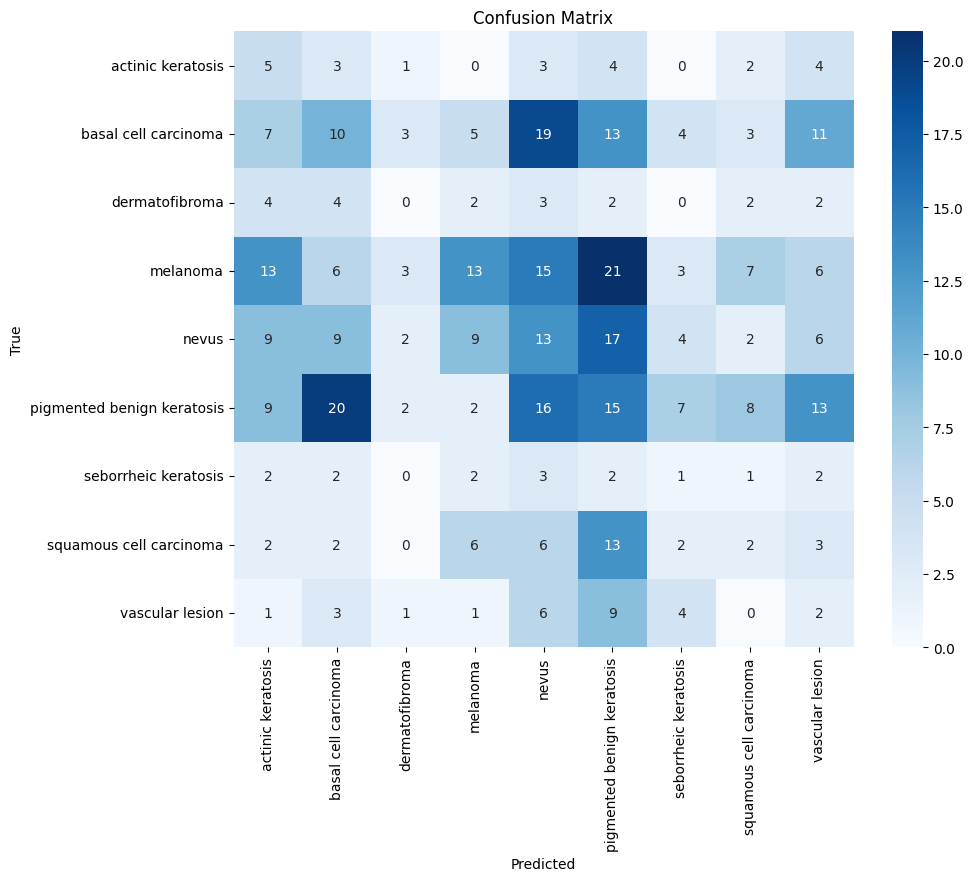

In [ ]:
# confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Deeper CNN + Regularization

In [ ]:
# 1. Imports & Settings
import os, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    BatchNormalization, Flatten,
    Dense, Dropout
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Paths & constants
TRAIN_DIR    = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
IMAGE_SIZE   = (150, 150)
TARGET_COUNT = 550  # per class
NUM_CLASSES  = 9

label_map = {
    'actinic keratosis':        0,
    'basal cell carcinoma':     1,
    'dermatofibroma':           2,
    'melanoma':                 3,
    'nevus':                    4,
    'pigmented benign keratosis': 5,
    'seborrheic keratosis':     6,
    'squamous cell carcinoma':  7,
    'vascular lesion':          8
}

#  Data Loading & Manual Augmentation
augmentor = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    fill_mode='nearest'
)

X_data, y_data = [], []

# Augmentation & Loading
for class_name, label in label_map.items():
    class_path = os.path.join(TRAIN_DIR, class_name)
    images = os.listdir(class_path)
    count = len(images)

    # Load original images
    for img_file in images:
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path).resize(IMAGE_SIZE)
            img_array = np.array(img) / 255.0
            X_data.append(img_array)
            y_data.append(label)
        except:
            continue

    # Augment to reach target count
    while count < TARGET_COUNT:
        img_file = random.choice(images)
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path).resize(IMAGE_SIZE)
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, 0)
            aug_img = augmentor.flow(img_array, batch_size=1)[0][0]
            X_data.append(aug_img)
            y_data.append(label)
            count += 1
        except:
            continue

print("Data augmentation complete.")

Data augmentation complete.


In [ ]:
#  Convert to NumPy Arrays
X_data = np.array(X_data)
y_data = np.array(y_data)
print("Shape of X:", X_data.shape)
print("Shape of y:", y_data.shape)


Shape of X: (4950, 150, 150, 3)
Shape of y: (4950,)


In [ ]:
#  Train/Val Split & One-Hot
X_train, X_val, y_train, y_val = train_test_split(
    X_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat   = to_categorical(y_val,   NUM_CLASSES)


In [ ]:
print("Final X_train shape:", X_train.shape)
print("Final y_train shape (one-hot):", y_train_cat.shape)
print("Final X_val shape:", X_val.shape)
print("Final y_val shape (one-hot):", y_val_cat.shape)


Final X_train shape: (3960, 150, 150, 3)
Final y_train shape (one-hot): (3960, 9)
Final X_val shape: (990, 150, 150, 3)
Final y_val shape (one-hot): (990, 9)


In [ ]:
#  Compute Class Weights
class_ids = np.unique(y_train)

#  Compute balanced weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=class_ids,
    y=y_train
)

# 3 Build the dict mapping each class ID → weight
class_weights = dict(zip(class_ids, weights))
print("Class weights for deeper model:", class_weights)

Class weights for deeper model: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0), np.int64(3): np.float64(1.0), np.int64(4): np.float64(1.0), np.int64(5): np.float64(1.0), np.int64(6): np.float64(1.0), np.int64(7): np.float64(1.0), np.int64(8): np.float64(1.0)}


**ADAM**

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(150, 150, 3)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),

              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 9, 9, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,138,185 (15.79 MB)

 Trainable params: 4,136,201 (15.78 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# Common Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=35,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]

)

Epoch 1/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.2553 - loss: 2.1602 - val_accuracy: 0.1111 - val_loss: 2.5360 - learning_rate: 1.0000e-04
Epoch 2/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4343 - loss: 1.6514 - val_accuracy: 0.1657 - val_loss: 2.8360 - learning_rate: 1.0000e-04
Epoch 3/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.5241 - loss: 1.5080 - val_accuracy: 0.2030 - val_loss: 2.6364 - learning_rate: 1.0000e-04
Epoch 4/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5515 - loss: 1.4462 - val_accuracy: 0.3505 - val_loss: 1.8671 - learning_rate: 1.0000e-04
Epoch 5/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6131 - loss: 1.3264 - val_accuracy: 0.5636 - val_loss: 1.4404 - learning_rate: 1.0000e-04
Epoch 6/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.6435 - loss: 1.2812 - val_accuracy: 0.5879 - val_loss: 1.3510 - learning_rate: 1.0000e-04
Epoch 7/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step -

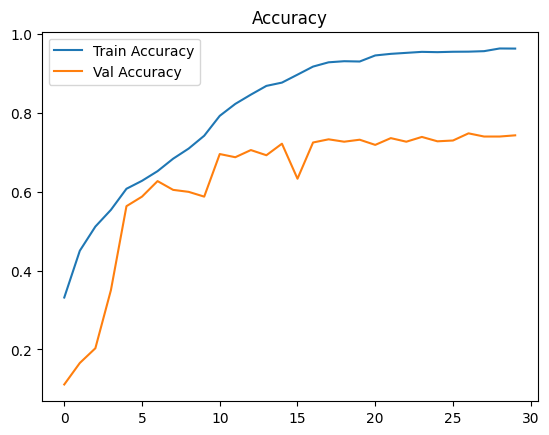

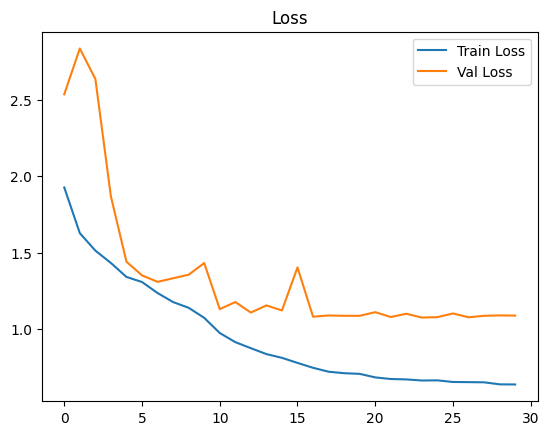

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70       110
           1       0.71      0.71      0.71       110
           2       0.88      0.87      0.88       110
           3       0.53      0.56      0.55       110
           4       0.70      0.63      0.66       110
           5       0.71      0.74      0.72       110
           6       0.70      0.73      0.71       110
           7       0.74      0.74      0.74       110
           8       0.97      0.99      0.98       110

    accuracy                           0.74       990
   macro avg       0.74      0.74      0.74       990
weighted avg       0.74      0.74      0.74       990



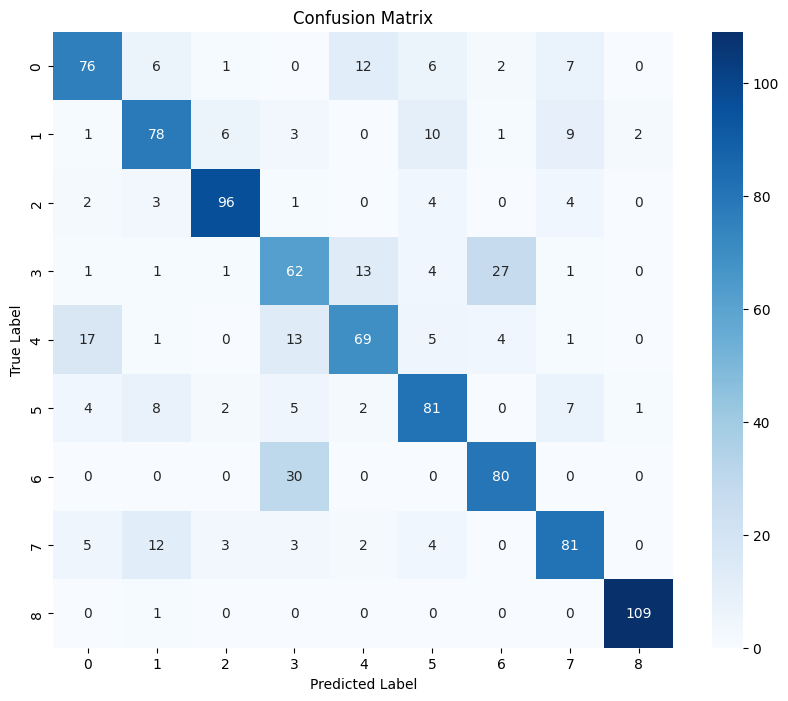

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


**SDG**

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import SGD

model = Sequential([
    Input(shape=(150, 150, 3)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])


model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])


model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 18, 18, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 9, 9, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,138,185 (15.79 MB)

 Trainable params: 4,136,201 (15.78 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=35,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]

)

Epoch 1/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.2189 - loss: 2.2177 - val_accuracy: 0.1141 - val_loss: 2.2097 - learning_rate: 0.0010
Epoch 2/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3894 - loss: 1.7361 - val_accuracy: 0.1475 - val_loss: 2.3036 - learning_rate: 0.0010
Epoch 3/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4481 - loss: 1.6013 - val_accuracy: 0.2919 - val_loss: 1.9997 - learning_rate: 0.0010
Epoch 4/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5064 - loss: 1.5098 - val_accuracy: 0.4475 - val_loss: 1.6384 - learning_rate: 0.0010
Epoch 5/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5447 - loss: 1.4529 - val_accuracy: 0.4576 - val_loss: 1.5612 - learning_rate: 0.0010
Epoch 6/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5644 - loss: 1.4027 - val_accuracy: 0.2747 - val_loss: 2.2881 - learning_rate: 0.0010
Epoch 7/35
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5853 - los

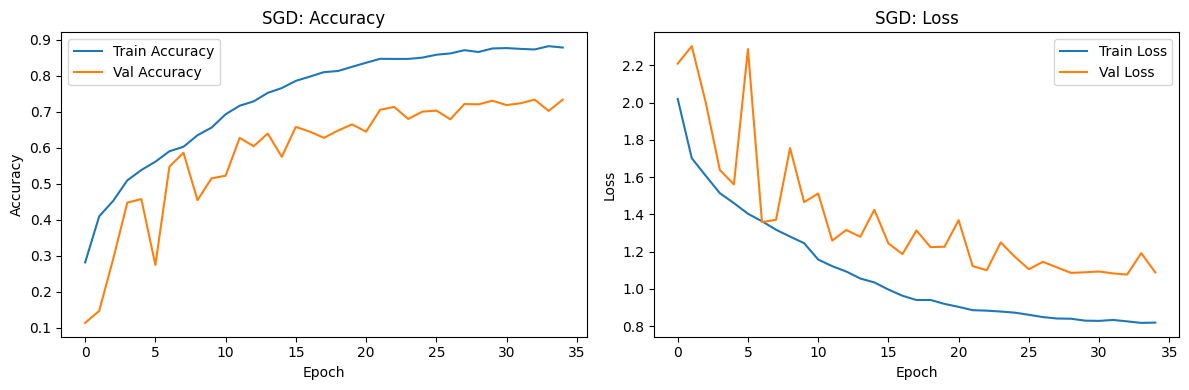

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("SGD: Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("SGD: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
SGD Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.70      0.80      0.75       110
      basal cell carcinoma       0.63      0.63      0.63       110
            dermatofibroma       0.90      0.85      0.88       110
                  melanoma       0.55      0.54      0.54       110
                     nevus       0.76      0.65      0.70       110
pigmented benign keratosis       0.67      0.75      0.70       110
      seborrheic keratosis       0.70      0.75      0.73       110
   squamous cell carcinoma       0.75      0.65      0.70       110
           vascular lesion       0.96      0.98      0.97       110

                  accuracy                           0.73       990
                 macro avg       0.74      0.73      0.73       990
              weighted avg       0.74      0.73      0.73       990



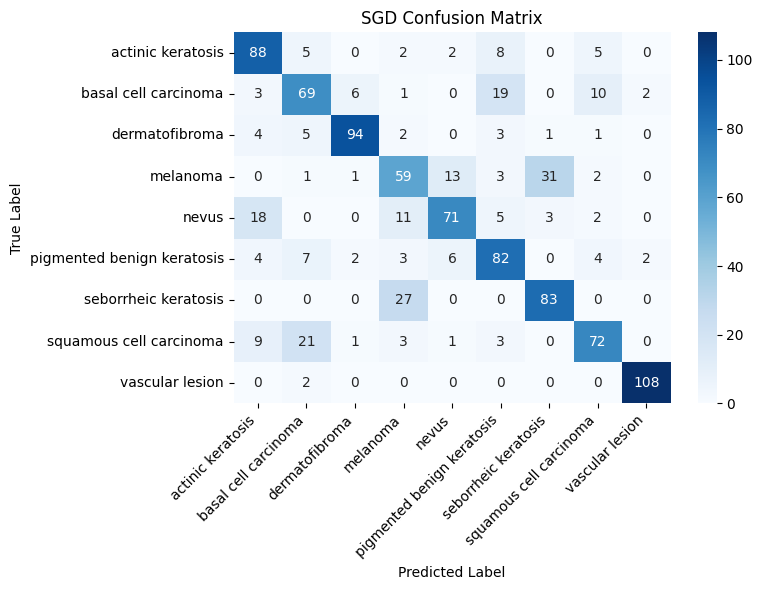

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Predict
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

# Classification Report
print("SGD Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_map.keys())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.title("SGD Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Transfer Learning

In [ ]:
import numpy as np
import pandas as pd

import os, random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
def create_dataframe(data_dir):
    data = [
        {"image_path": os.path.join(data_dir, dir_name, fname), "label": label}
        for label, dir_name in enumerate(os.listdir(data_dir))
        for fname in os.listdir(os.path.join(data_dir, dir_name))
    ]
    return pd.DataFrame(data)

train_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
df = create_dataframe(train_dir)

label_map = {i: label for i, label in enumerate(os.listdir(train_dir))}
num_classes = len(label_map)
df = df.groupby("label").head(700).reset_index(drop=True)


In [ ]:
from tqdm import tqdm

# Resize all images
df['image'] = df['image_path'].apply(lambda path: np.asarray(Image.open(path).resize((100, 75))).astype(np.uint8))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

for label in df['label'].unique():
    class_df = df[df['label'] == label]
    needed = 700 - len(class_df)

    augmented_df = pd.concat([augmented_df, class_df], ignore_index=True)

    for i in range(needed):
        img_array = np.expand_dims(random.choice(class_df['image'].values), axis=0)
        augmented_img = datagen.flow(img_array, batch_size=1)[0][0].astype(np.uint8)
        new_row = pd.DataFrame([{'image_path': None, 'label': label, 'image': augmented_img}])
        augmented_df = pd.concat([augmented_df, new_row], ignore_index=True)

df = augmented_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
X = np.array(df['image'].tolist())
y = to_categorical(df['label'].astype(int), num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_val.mean()) / X_val.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Reshape
X_train = X_train.reshape(-1, 75, 100, 3)
X_val = X_val.reshape(-1, 75, 100, 3)
X_test = X_test.reshape(-1, 75, 100, 3)


In [ ]:
from tensorflow.keras.applications import DenseNet201
from keras.models import Sequential
from keras.optimizers import SGD
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#  Load pre-trained DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(75, 100, 3))
base_model.trainable = False  # Freeze for feature extraction phase

#  Build model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
#  Compile (initial training with frozen base)
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#  Learning rate reduction
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5)

#  Initial training
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    callbacks=[lr_reduction])


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 126s 512ms/step - accuracy: 0.2909 - loss: 4.2119 - val_accuracy: 0.4792 - val_loss: 2.4156 - learning_rate: 0.0010
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.4702 - loss: 2.4443 - val_accuracy: 0.5407 - val_loss: 2.2859 - learning_rate: 0.0010
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5090 - loss: 2.3435 - val_accuracy: 0.5704 - val_loss: 2.1804 - learning_rate: 0.0010
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.5148 - loss: 2.2869 - val_accuracy: 0.5853 - val_loss: 2.1208 - learning_rate: 0.0010
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5553 - loss: 2.1934 - val_accuracy: 0.6012 - val_loss: 2.0876 - learning_rate: 0.0010
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5640 - loss: 2.1435 - val_accuracy: 0.6121 - val_loss: 2.0234 - learning_rate: 0.0010
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5912 - los

In [ ]:
#  Fine-tuning
#  Unfreeze the last 30 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 6. Recompile for fine-tuning
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)


In [ ]:

#  Callbacks for fine-tuning
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
fine_tune_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5)

#  Fine-tuning phase
fine_tune_history = model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=20,
                              batch_size=32,
                              callbacks=[fine_tune_lr, early_stop])

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 168s 793ms/step - accuracy: 0.6460 - loss: 2.0952 - val_accuracy: 0.7202 - val_loss: 1.8581 - learning_rate: 1.0000e-05
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.7085 - loss: 1.8140 - val_accuracy: 0.7232 - val_loss: 1.7814 - learning_rate: 1.0000e-05
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.7462 - loss: 1.6833 - val_accuracy: 0.7302 - val_loss: 1.7159 - learning_rate: 1.0000e-05
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.7510 - loss: 1.6279 - val_accuracy: 0.7302 - val_loss: 1.6612 - learning_rate: 1.0000e-05
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7617 - loss: 1.5509 - val_accuracy: 0.7351 - val_loss: 1.6126 - learning_rate: 1.0000e-05
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.7723 - loss: 1.4898 - val_accuracy: 0.7371 - val_loss: 1.5723 - learning_rate: 1.0000e-05
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/st

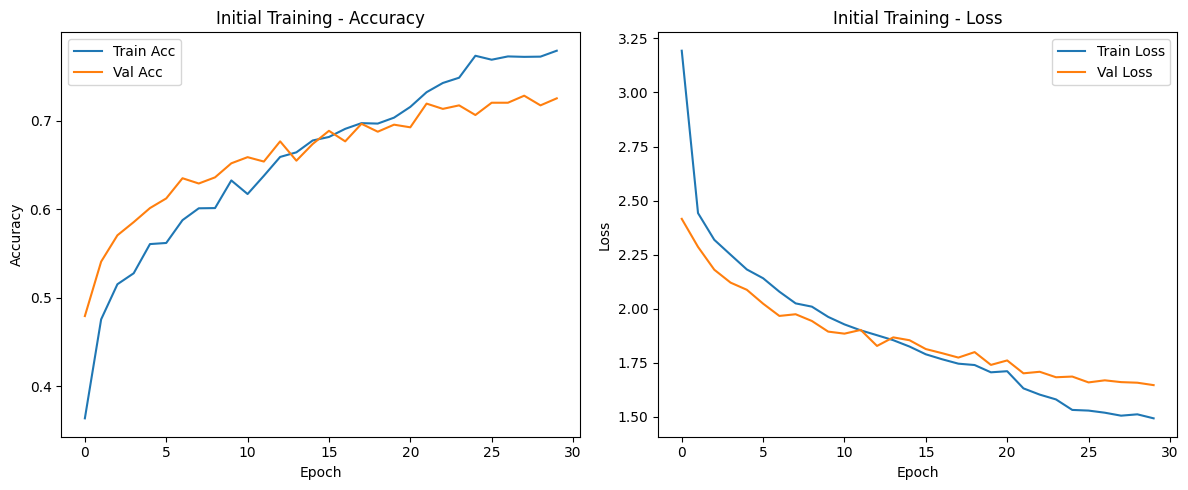

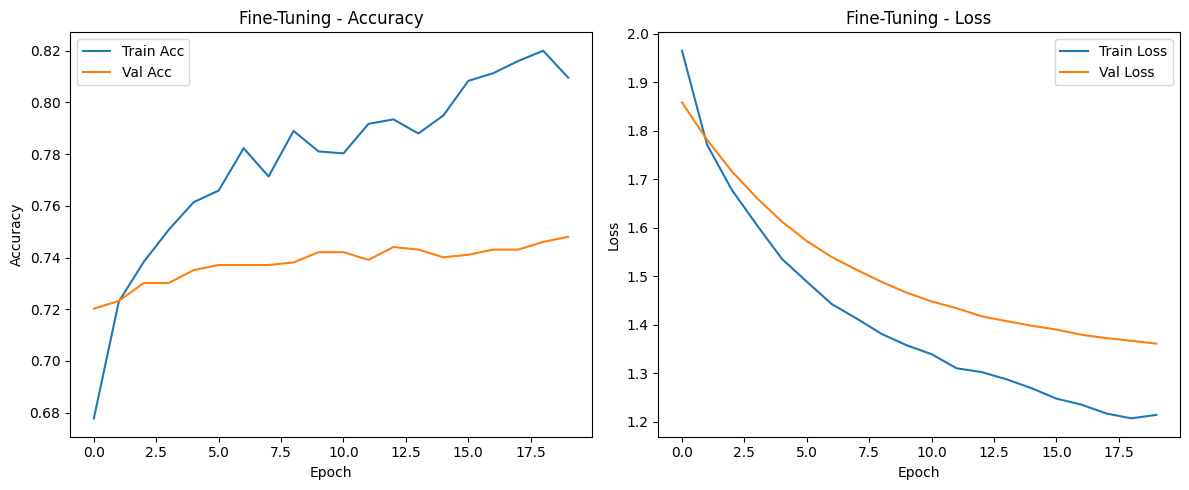

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history, title='Training History'):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot both phases
plot_history(history, title='Initial Training')
plot_history(fine_tune_history, title='Fine-Tuning')


In [ ]:
# Normalize and reshape test set if not already
X_test = (X_test - X_test.mean()) / X_test.std()
X_test = X_test.reshape(-1, 75, 100, 3)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 702ms/step - accuracy: 0.7314 - loss: 1.3550

Test Accuracy: 0.7421
 Test Loss: 1.3354


40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 792ms/step
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       123
           1       0.70      0.59      0.64       148
           2       0.96      0.97      0.97       143
           3       0.72      0.71      0.72       152
           4       0.76      0.64      0.69       133
           5       0.68      0.69      0.68       145
           6       0.64      0.80      0.71       147
           7       0.73      0.85      0.79       136
           8       0.86      0.92      0.89       133

    accuracy                           0.74      1260
   macro avg       0.74      0.74      0.74      1260
weighted avg       0.74      0.74      0.74      1260



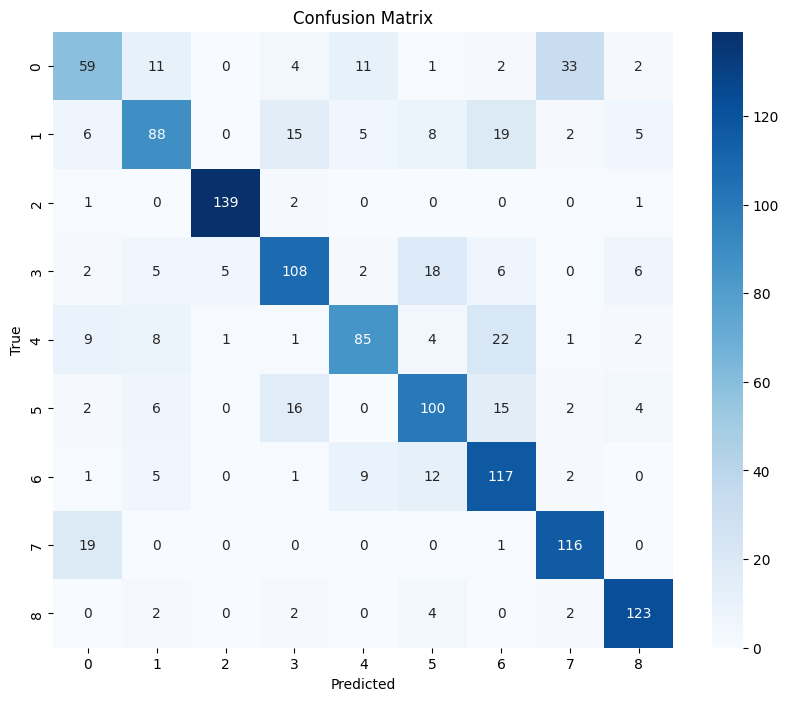

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict classes
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_labels, y_pred_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
